<a href="https://colab.research.google.com/github/roshanharip/TransGAN-Model-2.0/blob/main/TransGAN_Model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install torch torchvision transformers pillow matplotlib diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 75.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.3
    Uninstalling tokenizers-0.13.3:
      Successfully uninstalled tokenizers-0.13.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.25.1
    Uninstalling transformers-4.25.1:
      Successfully uninstalled transformers-4.25.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dalle-mini 0.1.5 requires transformers==4.25.1, but you have transformers 4.48.2 which is incompatible.


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Shared Cross-Modal Transformer (Using CLIP as a backbone)
class CrossModalTransformer(nn.Module):
    def __init__(self):
        super(CrossModalTransformer, self).__init__()
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    def forward(self, text=None, images=None):
        if text is not None:
            inputs = self.clip_processor(text=text, return_tensors="pt", padding=True).to(device)
            text_features = self.clip_model.get_text_features(**inputs)
            return text_features
        elif images is not None:
            inputs = self.clip_processor(images=images, return_tensors="pt").to(device)
            image_features = self.clip_model.get_image_features(**inputs)
            return image_features

In [ ]:
# Text-to-Image Generator (GAN-based)
class Generator(nn.Module):
    def __init__(self, latent_dim=256, img_channels=3, feature_map_size=64):  # Updated latent_dim to 256
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.init_size = 64 // 4
        self.l1 = nn.Linear(latent_dim, 128 * self.init_size ** 2)

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, img_channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [ ]:
# Image-to-Text Decoder (Transformer-based)
class ImageToTextDecoder(nn.Module):
    def __init__(self):
        super(ImageToTextDecoder, self).__init__()
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        self.model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
        self.image_projection = nn.Linear(512, 768).to(device)  # Project CLIP image features to GPT-2 embedding space

    def forward(self, input_ids, image_features, attention_mask=None):
        # Project image features to GPT-2 embedding space
        projected_image_features = self.image_projection(image_features).unsqueeze(1)  # Shape: (batch_size, 1, 768)

        # Concatenate projected image features with input embeddings
        embeddings = self.model.transformer.wte(input_ids)  # Token embeddings
        embeddings = torch.cat([projected_image_features, embeddings], dim=1)  # Add image features as prefix

        # Adjust attention mask to account for the added image feature
        if attention_mask is not None:
            attention_mask = torch.cat([torch.ones(attention_mask.size(0), 1).to(device), attention_mask], dim=1)

        # Pass through GPT-2 model
        outputs = self.model(inputs_embeds=embeddings, attention_mask=attention_mask)
        return outputs.logits



In [ ]:
# Unified Framework
class UnifiedFramework(nn.Module):
    def __init__(self):
        super(UnifiedFramework, self).__init__()
        self.cross_modal_transformer = CrossModalTransformer()
        self.decoder = ImageToTextDecoder()

        # Load pre-trained Stable Diffusion for text-to-image generation
        self.stable_diffusion = StableDiffusionPipeline.from_pretrained(
            "CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16
        ).to(device)

    def text_to_image(self, text):
        # Generate an image using Stable Diffusion
        generated_image = self.stable_diffusion(text).images[0]
        return generated_image

    def image_to_text(self, image, max_length=50):
        image_features = self.cross_modal_transformer(images=image)
        input_ids = torch.tensor([[self.decoder.tokenizer.bos_token_id]]).to(device)
        attention_mask = torch.ones_like(input_ids).to(device)

        for _ in range(max_length):
            logits = self.decoder(input_ids, image_features, attention_mask)
            next_token = torch.argmax(logits[:, -1, :], dim=-1).unsqueeze(-1)
            input_ids = torch.cat([input_ids, next_token], dim=-1)
            attention_mask = torch.cat([attention_mask, torch.ones_like(next_token).to(device)], dim=-1)

            if next_token.item() == self.decoder.tokenizer.eos_token_id:
                break

        return self.decoder.tokenizer.decode(input_ids[0], skip_special_tokens=True)


In [ ]:
# Helper function to visualize images
def visualize_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Generated Image:


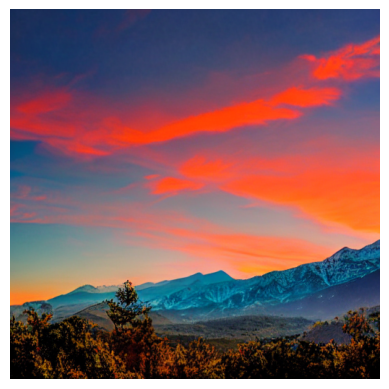

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Generated Text: The U.S. Department of Justice has filed a lawsuit against the company that owns the video game company, Electronic Arts, alleging that the company's games are infringing on the First Amendment rights of its players.

The lawsuit, filed in U


In [ ]:
# Example Usage
if __name__ == "__main__":
    # Initialize the unified framework
    model = UnifiedFramework().to(device)

    # Example Text-to-Image
    text_input = "A beautiful sunset over the mountains"
    generated_image = model.text_to_image(text_input)
    print("Generated Image:")
    visualize_image(generated_image)
# Example Image-to-Text
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image_input = Image.open("example_img.jpg").convert("RGB")
    image_input = transform(image_input).unsqueeze(0).to(device)
    generated_text = model.image_to_text(image_input)
    print("Generated Text:", generated_text)